In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

data = pd.read_csv('data/train.csv')

In [2]:
# Drop the ID column
data = data.drop('id', axis=1)

# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])

# Extract date components
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month 
data['year'] = data['date'].dt.year
data['day_of_week'] = data['date'].dt.dayofweek

# Display the first few rows to verify changes
data.head()

,date,country,store,product,num_sold,day,month,year,day_of_week
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,1,1,2010,4
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,1,1,2010,4
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,1,1,2010,4
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,1,1,2010,4
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,1,1,2010,4


In [4]:
import requests

def get_gdp_per_capita(alpha3, year):
    url='https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json'
    response = requests.get(url.format(alpha3,year)).json()
    return response[1][0]['value']

def add_gdp_features(df):
    alpha3s = ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP']
    df['alpha3'] = df['country'].map(dict(zip(
        np.sort(df['country'].unique()), alpha3s)))
    years = np.sort(df['date'].dt.year.unique())
    gdp = np.array([
        [get_gdp_per_capita(alpha3, year) for year in years]
        for alpha3 in alpha3s
    ])
    gdp = pd.DataFrame(gdp/gdp.sum(axis=0), index=alpha3s, columns=years)
    df['GDP'] = df.apply(lambda s: gdp.loc[s['alpha3'], s['year']], axis=1)
    
    df.drop("alpha3", axis=1, inplace=True)

In [5]:
def add_holiday_features(df):
    alpha2 = dict(zip(np.sort(df.country.unique()), ['CA', 'FI', 'IT', 'KE', 'NO', 'SG']))
    h = {c: holidays.country_holidays(a, years=range(2010, 2020)) for c, a in alpha2.items()}
    
    df['is_holiday'] = 0
    df['days_to_holiday'] = 0
    
    for c in alpha2:
        country_mask = df.country == c
        # Convert holiday dates to pandas Timestamps
        holiday_dates = pd.to_datetime(list(h[c].keys()))
        
        # Set is_holiday flag
        df.loc[country_mask, 'is_holiday'] = df.loc[country_mask, 'date'].isin(holiday_dates).astype(int)
        
        # Calculate days to nearest holiday for each date
        for idx in df[country_mask].index:
            date = df.loc[idx, 'date']
            # Calculate forward and backward distances to holidays
            future_holidays = holiday_dates[holiday_dates >= date]
            past_holidays = holiday_dates[holiday_dates <= date]
            
            days_forward = float('inf')
            days_backward = float('inf')
            
            if len(future_holidays) > 0:
                days_forward = (future_holidays.min() - date).days
            if len(past_holidays) > 0:
                days_backward = (date - past_holidays.max()).days
                
            df.loc[idx, 'days_to_holiday'] = min(days_forward, days_backward)

In [6]:
add_gdp_features(data)
add_holiday_features(data)

In [7]:
data["num_sold"] /= data["GDP"]
store_ratio = data.groupby("store").num_sold.mean().to_dict()
data["store_ratio"] = data.store.map(store_ratio)
data["num_sold"] /= data["store_ratio"]

In [8]:
data

,date,country,store,product,num_sold,day,month,year,day_of_week,GDP,is_holiday,days_to_holiday,store_ratio
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,1,1,2010,4,0.178301,1,0,2490.001520
1,2010-01-01,Canada,Discount Stickers,Kaggle,2.191586,1,1,2010,4,0.178301,1,0,2490.001520
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,2.040675,1,1,2010,4,0.178301,1,0,2490.001520
3,2010-01-01,Canada,Discount Stickers,Kerneler,0.952765,1,1,2010,4,0.178301,1,0,2490.001520
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,1.105929,1,1,2010,4,0.178301,1,0,2490.001520
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,0.352565,31,12,2016,5,0.231100,0,1,5719.338853
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2.199372,31,12,2016,5,0.231100,0,1,5719.338853
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,1.739372,31,12,2016,5,0.231100,0,1,5719.338853
230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,0.939670,31,12,2016,5,0.231100,0,1,5719.338853


In [11]:
C = list( data.country.unique() )
S = list( data.store.unique() )
P = list( data["product"].unique() )
print("Countries:", C )
print("Stores:", S )
print("Products:", P)

Countries: ['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore']
Stores: ['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart']
Products: ['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode']


In [12]:
input = np.zeros((5,2557,18))  # Initialize empty array
for i in range(5):      # Loop through products
    for j in range(3):  # Loop through stores
        for k in range(6):  # Loop through countries
            f = 1 
            if k==3: f=1.15  # Apply 1.15 multiplier for Kenya (4th country)
            
            # Get sales data for this product-store-country combination
            df = data.loc[(data.country==C[k])&
                          (data.store==S[j])&
                          (data["product"]==P[i])].copy()
            
            # Store in array at position [product, :, store*6 + country]
            input[i,:,j*6+k] = df["num_sold"].values*f

In [14]:
input.shape

(5, 2557, 18)

### data loader


In [15]:
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, product=0, f_length=768, t_length=32): 

        self.data = np.expand_dims(data,axis=-1)
        nans = np.isnan(self.data).astype('float32')
        self.data = np.concatenate([self.data,nans],axis=-1)
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.product = product
        self.f_length = f_length
        self.t_length = t_length
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int(np.ceil(32*1024/self.batch_size))
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( 32*1024 )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
    
        SIZE = self.f_length
        TARGET = self.t_length
        X = np.zeros((len(indexes),SIZE,2),dtype='float32')
        y = np.zeros((len(indexes),TARGET),dtype='float32')
        
        for k in range(len(indexes)):
            r = np.random.randint(0,self.data.shape[2])
            a = np.random.randint(0,self.data.shape[1]-SIZE-TARGET)
            y[k,:] = self.data[self.product,a+SIZE:a+SIZE+TARGET,r,0]
            while np.isnan(y[k,:]).sum()>0:
                r = np.random.randint(0,self.data.shape[2])
                a = np.random.randint(0,self.data.shape[1]-SIZE-TARGET)
                y[k,:] = self.data[self.product,a+SIZE:a+SIZE+TARGET,r,0]
            X[k,:,:] = self.data[self.product,a:a+SIZE,r,:]

        return np.nan_to_num(X),np.nan_to_num(y)

In [16]:
gen = DataGenerator(input)

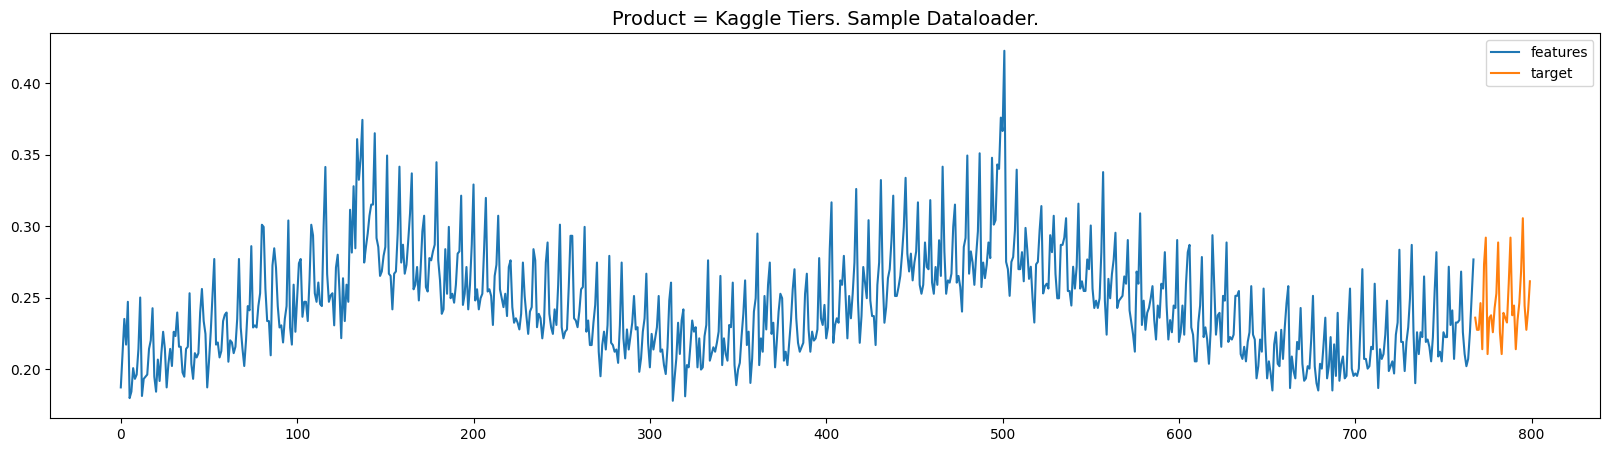

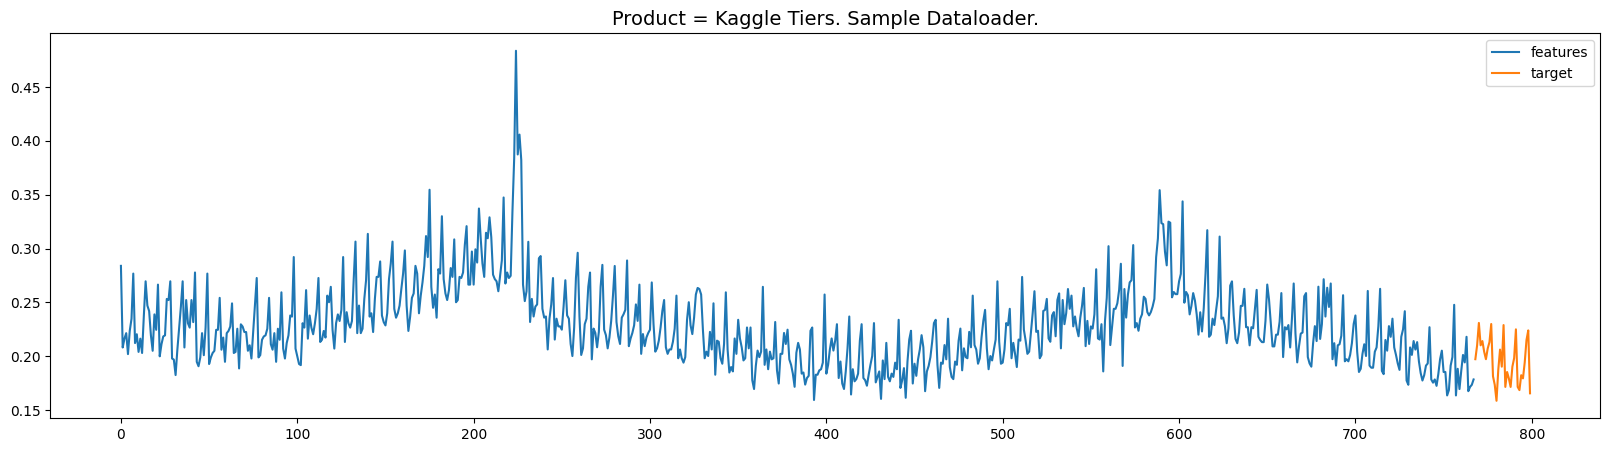

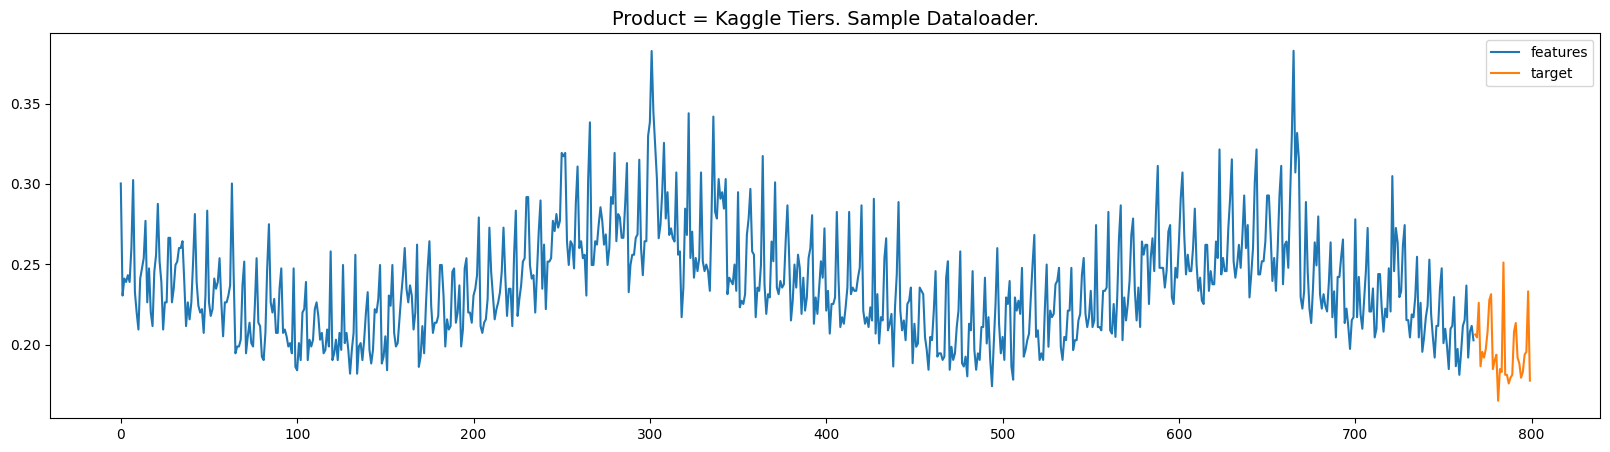

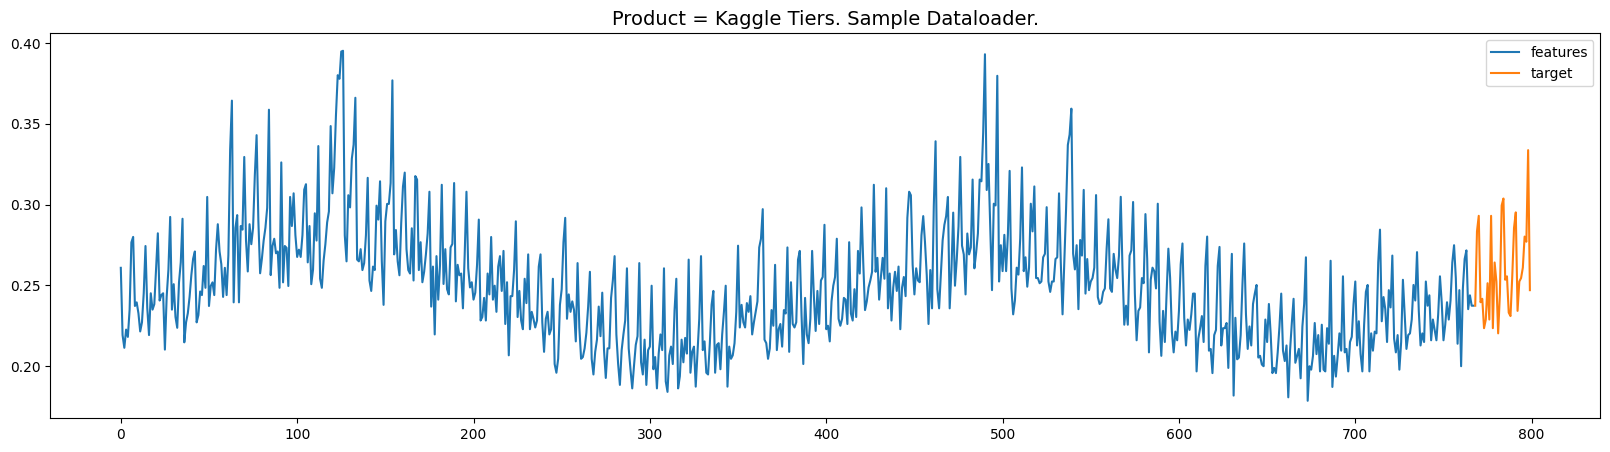

In [18]:
for x,y in gen:
    for k in range(4):
        plt.figure(figsize=(20,5))
        LN = x.shape[1]
        LN2 = y.shape[1]
        plt.plot(np.arange(LN),x[k,:,0],label='features')
        plt.plot(np.arange(LN2)+LN,y[k,:],label='target')
        plt.legend()
        plt.title(f"Product = {P[2]}. Sample Dataloader.",size=14)
        plt.show()
    break

In [34]:
# Define the Transformer model
from tensorflow import keras
from keras import layers

def create_transformer_model(input_shape, output_length):
    # Input layer
    inputs = keras.Input(shape=input_shape)
    
    # Add positional encoding
    pos_encoding = layers.Embedding(input_shape[0], input_shape[1])(
        tf.range(start=0, limit=input_shape[0], delta=1))
    x = layers.Add()([inputs, pos_encoding])
    
    # Transformer encoder
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.MultiHeadAttention(
        num_heads=4, key_dim=64)(x, x)
    x = layers.Dropout(0.1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Conv1D(filters=128, kernel_size=1, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    # Global average pooling and dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(output_length)(x)
    
    return keras.Model(inputs=inputs, outputs=outputs)

# Create and compile the model
input_shape = (x.shape[1], x.shape[2])  # From the generator output shape
output_length = y.shape[1]  # Target sequence length
model = create_transformer_model(input_shape, output_length)

# Create separate generators for training and validation
train_gen = DataGenerator(input, batch_size=32, shuffle=True)
val_gen = DataGenerator(input, batch_size=32, shuffle=False)  # Usually don't shuffle validation

# Compile model (unchanged)
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Train the model with separate generators
history = model.fit(
    train_gen,
    validation_data=val_gen,  # Use validation_data instead of validation_split
    epochs=50,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/50
